# Exercise 3B

In this exercise, you will explore how the DBSCAN clustering algorithm identifies dense groups and outliers in the Pokémon statistics dataset. You will analyze the dataset, scale features, determine DBSCAN parameters, run DBSCAN, and interpret the clustering results.

In [804]:
import kagglehub
import os
import pandas as pd

In [805]:
# Download latest version
path = kagglehub.dataset_download("abcsds/pokemon")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'pokemon' dataset.
Path to dataset files: /kaggle/input/pokemon


In [806]:
if os.path.isdir(path):
  print(True)

contents = os.listdir(path)
contents

mydataset = path + "/" + contents[0]
mydataset


df = pd.read_csv(mydataset)

True


## 1. Load the Dataset (8 pts)

Load the Pokémon dataset into a pandas DataFrame.

Show the first five rows (3 pts)

In [807]:
df.head(5)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False



How many Pokémon are in the dataset? (2 pts)


In [808]:
len(df)

800


List all columns available (3 pts)

In [809]:
df.columns

Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

## 2: Select Features & Clean the Data (8 pts)

Select the numeric features needed for clustering (HP, Attack, Defense, Sp. Atk, Sp. Def, Speed).

In [810]:
df_selected = df[[ 'Attack', 'Defense', 'Speed']]

Are there any missing values? (2 pts)

In [811]:
df_selected.isna().sum()

,0
Attack,0
Defense,0
Speed,0


If missing values exist, describe how you handled them (3 pts)

In [812]:
df_selected.dropna(inplace=True)
df_selected.isna().sum()

/tmp/ipython-input-4132730757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.dropna(inplace=True)


,0
Attack,0
Defense,0
Speed,0


# 3. Scale the Features (10 pts)

Apply StandardScaler to the selected features.

Show the transformed feature sample (e.g., first 5 rows) (10 pts)


In [813]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_selected)

scaled_df = pd.DataFrame(scaled_features, columns=df_selected.columns)
scaled_df.head()

,Attack,Defense,Speed
0,-0.924906,-0.797154,-0.801503
1,-0.524130,-0.347917,-0.285015
2,0.092448,0.293849,0.403635
3,0.647369,1.577381,0.403635
4,-0.832419,-0.989683,-0.112853


## 4. Determine a Suitable eps Value (10 pts)

Using k = 4:
Compute the distance to the 4th nearest neighbor for each Pokémon (6 pts)

In [814]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

In [815]:
nn = NearestNeighbors(n_neighbors=4).fit(scaled_df)
distances, indices = nn.kneighbors(scaled_df)

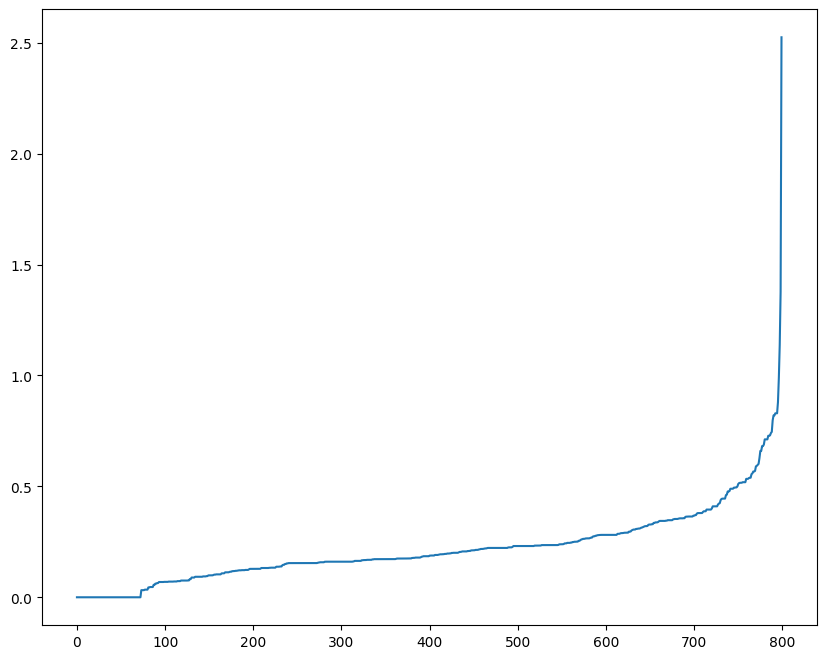

In [816]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,8))
plt.plot(distances)

In [817]:
min_samples = range(2,5)
epsilon = np.arange(1, 2.0, 0.05)
epsilon

output = []

for ms in min_samples:
    for ep in epsilon:
        labels = DBSCAN(min_samples=ms, eps = ep).fit(scaled_df).labels_
        score = metrics.silhouette_score(scaled_df, labels)
        output.append((ms, ep, score))

In [818]:
min_samples, eps, score = sorted(output, key=lambda x:x[-1])[-1]
print(f"Best silhouette_score: {score}")
print(f"min_samples: {min_samples}")
print(f"eps: {eps}")

Best silhouette_score: 0.6256236080101283
min_samples: 4
eps: 1.9500000000000008


What is your chosen eps based on the "elbow"? (2 pts)

**1.9**

One-sentence explanation of your reasoning (2 pts)

**:using both the elbow method on the plot, and the silhouette score produced similar results**

## 5. Run DBSCAN (10 points)

Run DBSCAN using your chosen eps and min_samples


How many clusters did DBSCAN find? (4 pts)

In [819]:
ep = eps
dbscan = DBSCAN(eps = ep, min_samples=min_samples).fit(scaled_df)
labels = dbscan.labels_

# Number of clusters in labels
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Number of noise
n_noise_ = list(labels).count(-1)

silhouette_score = metrics.silhouette_score(scaled_df, labels)

How many Pokémon were labeled as noise? (4 pts)

In [820]:
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette score", silhouette_score)

Estimated number of clusters: 1
Estimated number of noise points: 1
Silhouette score 0.6256236080101283


Show the unique labels output by DBSCAN (2 pts)

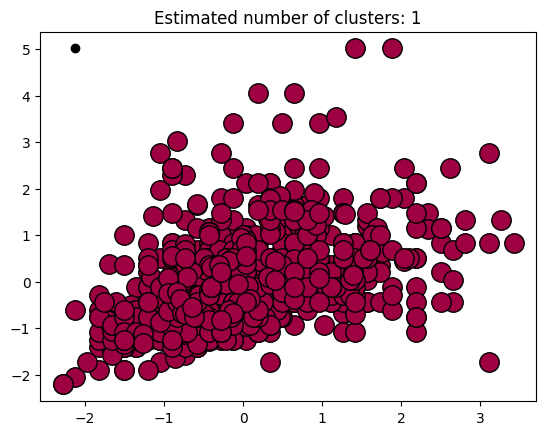

In [822]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = scaled_df[class_member_mask & core_samples_mask]
    plt.plot(
        xy.iloc[:, 0],
        xy.iloc[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = scaled_df[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy.iloc[:, 0],
        xy.iloc[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

## 6. Attach Cluster Labels to the Original Dataset (7 points)

Add the cluster labels back to the original DataFrame (3 pts)

In [823]:
df['cluster'] = labels

Show the first 10 rows including the cluster label (4 pts)

In [824]:
df.head(10)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,cluster
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,0
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,0
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,0
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,0
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,0
5,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False,0
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False,0
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False,0
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False,0
9,7,Squirtle,Water,NaN,314,44,48,65,50,64,43,1,False,0


## 7. Explore the Clusters (12 points)

For each cluster:


How many Pokémon does it contain? (4 pts)

In [825]:
df['cluster'].value_counts()

,count
cluster,
0,799
-1,1


What are the average Attack, Defense, and Speed? (4 pts)


In [826]:
df['Attack'].mean()
df['Defense'].mean()
df['Speed'].mean()

np.float64(68.2775)

Compare the clusters: What differences do you notice? (4 pts)

In [827]:
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,cluster
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,0
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,0
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,0
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,0
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,0


## 8. Identify Outliers (10 points)

List all Pokémon labeled as noise (cluster = -1) (4 pts)



In [828]:
print(df[df['cluster'] == -1])

       #     Name Type 1 Type 2  Total  HP  Attack  Defense  Sp. Atk  Sp. Def  \
230  213  Shuckle    Bug   Rock    505  20      10      230       10      230   

     Speed  Generation  Legendary  cluster  
230      5           2      False       -1  


Are many of them legendary? (3 pts)

**None are legendary, only a single pokemon named Shuckle is selected**

Explain why DBSCAN might classify them as outliers (3 pts)

In [829]:
# put your answer here

## 9. Interpret the Clustering Results (25 points)
Write a short interpretation (4–6 sentences).
Discuss:


What types of Pokémon grouped together (5 pts)

In [830]:
# put your answer here

Whether the clusters make intuitive sense (10 pts)

In [831]:
# put your answer here


What the noise points reveal about DBSCAN (5 pts)


In [832]:
# put your answer here

What stat patterns you discovered (5 pts)

In [833]:
# put your answer here